In [1]:
# Constant filepaths
imgs_path = 'img_align_celeba/'
att_path = 'list_attr_celeba.txt'

In [2]:
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import time
import os

In [27]:
Attributes = pd.read_csv(att_path, delim_whitespace=True)[["Name", "Eyeglasses"]]

Attributes['Eyeglasses'] = Attributes['Eyeglasses'].replace([-1],0)

#Count number of images, w/o glasses
class0_size = len(Attributes[Attributes["Eyeglasses"] == 0])

#Count number of images, w glasses
class1_size = len(Attributes[Attributes["Eyeglasses"] == 1])

#check if class1 + class2 = file size 

print(class0_size + class1_size == len(Attributes))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 [0, 1],
                                                 Attributes['Eyeglasses'])

print(class_weights)

True
[0.5348273  7.67827636]


In [36]:
class CelebDataLoader(Dataset):

    def __init__(self, attr, root_dir, transform=None):

        self.attr = attr
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return int(len(self.attr) * (0.8)) 

    def __getitem__(self, idx):

        img_name = join(self.root_dir, self.attr.iloc[idx, 0])
        image = plt.imread(img_name)
        label = self.attr.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)


class CelebDataLoader_Test(Dataset):

    def __init__(self, attr, root_dir, transform=None):

        self.attr = attr
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return int(len(self.attr) * (0.2)) 

    def __getitem__(self, idx):

        new_idx = int(len(self.attr) - (idx + 1))
        img_name = join(self.root_dir, self.attr.iloc[new_idx, 0])
        image = plt.imread(img_name)
        label = self.attr.iloc[new_idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

In [37]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
celeb_dataset = CelebDataLoader(attr=Attributes, root_dir="img_align_celeba", transform = transform)
loader = torch.utils.data.DataLoader(celeb_dataset, batch_size=128, shuffle=True, num_workers=4)


celeb_dataset_test = CelebDataLoader_Test(attr=Attributes, root_dir="img_align_celeba", transform = transform)
loader_test = torch.utils.data.DataLoader(celeb_dataset_test, batch_size=128, shuffle=True, num_workers=4)


#Check if Cuda is Available!
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:0


torch.Size([3, 218, 178])


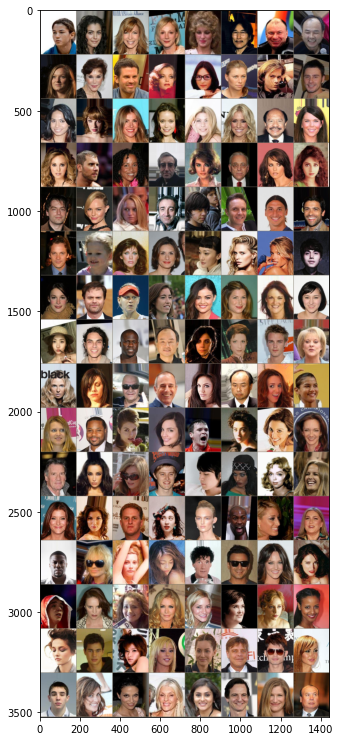

In [30]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(13, 13))

    plt.imshow(inp)
    plt.pause(0.001) 


inputs, labels = next(iter(loader_test))

out = torchvision.utils.make_grid(inputs)

print(np.shape(inputs[0]))
imshow(out)

In [31]:
def test_model(model, load_path='saved_weight.pth'):   
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()
    model.eval() 



    running_loss = 0.0
    running_corrects = 0
    size = 0
    for inputs, labels in loader_test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)
        size+= len(labels)
    epoch_acc = running_corrects.double() /  size
    print('{} Acc: {:.4f}'.format("Testing", epoch_acc))

    time_elapsed = time.time() - since

    return epoch_acc

In [8]:
def train_model(model, criterion, optimizer, num_epochs=1, save_path='saved_weight.pth'):
    since = time.time()
    Acc_list = []
    Test_acc_list = []
    model.train() 

    Batch_Acc = []
    
    print(" ---- Training is Activated ---- ")
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)


        running_loss = 0.0
        running_corrects = 0


        batchIdx = 0
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)


            num_of_Corrects = torch.sum(preds == labels.data)
            running_corrects += num_of_Corrects

            if batchIdx % 10 == 0:
              print(batchIdx, "--> loss = ", loss.item(), f'Number of Correct Preds = {num_of_Corrects} out of {len(inputs)}')
              torch.save(model.state_dict(), save_path)

              test_acc = test_model(model, load_path=save_path)
#               Test_acc_list.append(test_acc)
              Batch_Acc.append(num_of_Corrects/len(labels))


            batchIdx += 1
        epoch_loss = running_loss / len(celeb_dataset)
        epoch_acc = running_corrects.double() / len(celeb_dataset)
        Acc_list.append(epoch_acc)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format("Training", epoch_loss, epoch_acc))



    time_elapsed = time.time() - since
    # print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    return Batch_Acc, Test_acc_list

In [32]:
class EyeglassesClassifier(nn.Module):
    def __init__(self):
        super(EyeglassesClassifier, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 2)

    def forward(self, x):
        return self.backbone(x)

In [34]:
load_path='Eyeglasses_Classifier.pth'
Model = EyeglassesClassifier().to(device)
Model.load_state_dict(torch.load(load_path))

weights = torch.tensor([1/14, 1], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.SGD(Model.parameters(), lr=0.0001)
PATH ='Eyeglasses_Classifier.pth'
Training_Accuracies, Testing_Accuracies = train_model(Model, criterion, optimizer, num_epochs=1, save_path=PATH)
# test_model(ResNet18, load_path=PATH)

 ---- Training is Activated ---- 
Epoch 0/0
----------
0 --> loss =  0.12888085842132568 Number of Correct Preds = 122 out of 128
Testing Acc: 0.9951
10 --> loss =  0.04880798980593681 Number of Correct Preds = 125 out of 128
Testing Acc: 0.9951
20 --> loss =  0.0313819944858551 Number of Correct Preds = 125 out of 128
Testing Acc: 0.9951
30 --> loss =  0.058780424296855927 Number of Correct Preds = 126 out of 128
Testing Acc: 0.9951
40 --> loss =  0.03247756138443947 Number of Correct Preds = 126 out of 128
Testing Acc: 0.9951
50 --> loss =  0.04905708134174347 Number of Correct Preds = 125 out of 128
Testing Acc: 0.9951
60 --> loss =  0.03382790461182594 Number of Correct Preds = 127 out of 128
Testing Acc: 0.9951
70 --> loss =  0.018154289573431015 Number of Correct Preds = 126 out of 128
Testing Acc: 0.9951
80 --> loss =  0.04725499823689461 Number of Correct Preds = 125 out of 128
Testing Acc: 0.9951
90 --> loss =  0.06249958276748657 Number of Correct Preds = 126 out of 128
Testi

Testing Acc: 1.0000
840 --> loss =  0.016862347722053528 Number of Correct Preds = 127 out of 128
Testing Acc: 1.0000
850 --> loss =  0.009600145742297173 Number of Correct Preds = 128 out of 128
Testing Acc: 1.0000
860 --> loss =  0.018045417964458466 Number of Correct Preds = 128 out of 128
Testing Acc: 1.0000
870 --> loss =  0.052209775894880295 Number of Correct Preds = 127 out of 128
Testing Acc: 1.0000
880 --> loss =  0.004641587380319834 Number of Correct Preds = 128 out of 128
Testing Acc: 1.0000
890 --> loss =  0.009231142699718475 Number of Correct Preds = 128 out of 128
Testing Acc: 1.0000
900 --> loss =  0.008275057189166546 Number of Correct Preds = 128 out of 128
Testing Acc: 1.0000
910 --> loss =  0.010847424156963825 Number of Correct Preds = 127 out of 128
Testing Acc: 1.0000
920 --> loss =  0.014761649072170258 Number of Correct Preds = 127 out of 128
Testing Acc: 1.0000
930 --> loss =  0.01124520879238844 Number of Correct Preds = 128 out of 128
Testing Acc: 1.0000
9

In [38]:
test_acc = test_model(Model, load_path='Eyeglasses_Classifier.pth')

Testing Acc: 0.9938


In [26]:
integervalue = 10
'{0:05d}'.format(integervalue)

'00010'

In [39]:
## Download Sample of FFHQ dataset and test it manually! Meaning print some samples and check if model gives
## results as expected. 
load_path='Eyeglasses_Classifier.pth'
Model = EyeglassesClassifier().to(device)
Model.load_state_dict(torch.load(load_path))

FFHQ_dir = "00000-20220323T131828Z-001/00000"

In [40]:
class FFHQ_DataLoader(Dataset):

    def __init__(self,root_dir, transform=None):
        
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return 128 

    def __getitem__(self, idx):

        img_name = join(self.root_dir, '{0:05d}'.format(idx) + '.png')
        image = plt.imread(img_name)
        if self.transform:
            image = self.transform(image)
        return image, _

In [41]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
                                transforms.Resize((218, 178)),
                                ])
celeb_dataset = FFHQ_DataLoader(root_dir=FFHQ_dir, transform = transform)
loader = torch.utils.data.DataLoader(celeb_dataset, batch_size=64, shuffle=True, num_workers=0)


Traceback (most recent call last):
  File "/home/saud/anaconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/saud/anaconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/saud/anaconda3/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/home/saud/anaconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <function _ConnectionBase.__del__ at 0x7f970813adc0>
Traceback (most recent call last):
  File "/home/saud/anaconda3/lib/python3.9/multiprocessing/connection.py", line 137, in __del__
    self._close()
  File "/home/saud/anaconda3/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


torch.Size([3, 218, 178])


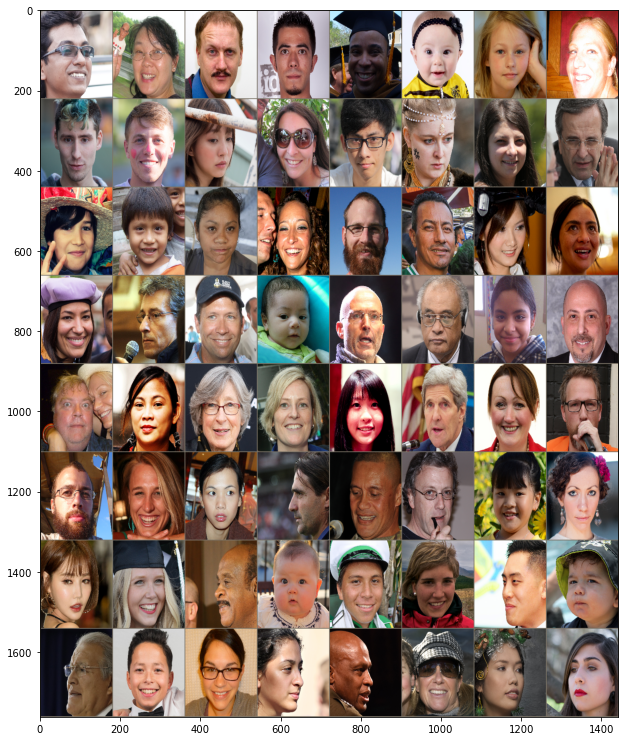

In [49]:
sample, _ = next(iter(loader))

out = torchvision.utils.make_grid(sample)

print(np.shape(sample[0]))
imshow(out)

In [50]:
outputs = Model(sample.to(device))
_, preds = torch.max(outputs, 1)

preds

tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')

torch.Size([3, 218, 178])


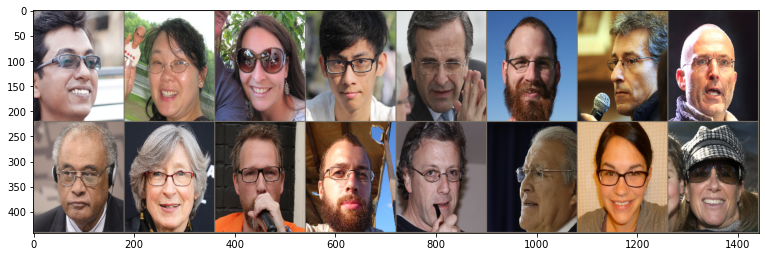

In [51]:
## Show only class 1

out = torchvision.utils.make_grid(sample[preds == 1])

print(np.shape(sample[0]))
imshow(out)

torch.Size([3, 218, 178])


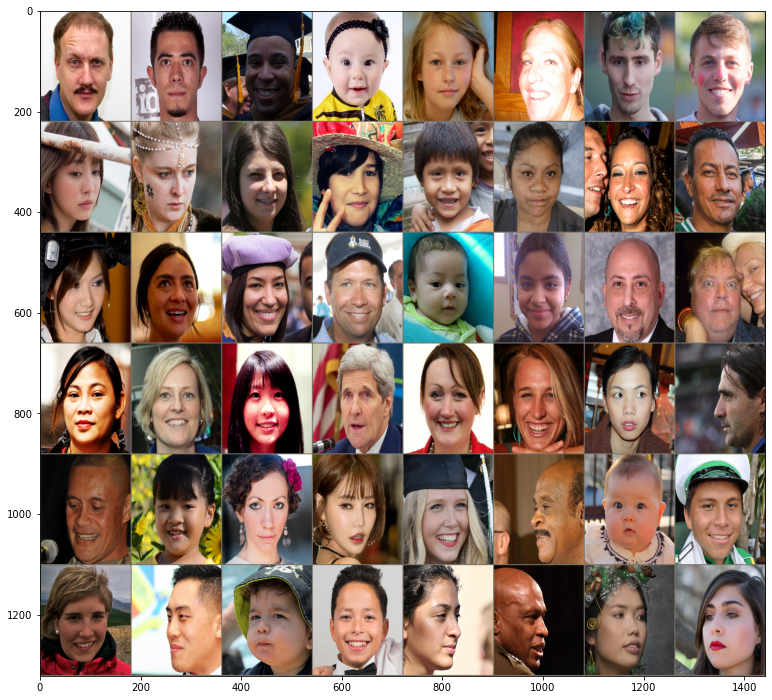

In [52]:
## Show only class 2

out = torchvision.utils.make_grid(sample[preds == 0])

print(np.shape(sample[0]))
imshow(out)